In [54]:
import os
import pickle
import random
from nats_bench import create
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from spektral.data import PackedBatchLoader
from sklearn.manifold import TSNE
from datasets.nb101_dataset import OP_PRIMITIVES_NB101, NasBench101Dataset
from datasets.nb201_dataset import OP_PRIMITIVES_NB201, NasBench201Dataset
from datasets.transformation import OnlyValidAccTransform, OnlyFinalAcc, LabelScale
from utils.tf_utils import to_undiredted_adj
import matplotlib as mpl
from datasets.nb201_dataset import OPS_by_IDX_201, ops_list_to_nb201_arch_str
api = create(None, 'tss', fast_mode=True, verbose=False)
mpl.rcParams['figure.dpi'] = 300
os.environ['CUDA_VISIBLE_DEVICES'] = ""

[2023-06-03 07:02:36] Try to use the default NATS-Bench (topology) path from fast_mode=True and path=None.


## Set model_dir with path of model which is trained by trainGAE_for_visualization.py

In [55]:
model_dir = 'logs/for_tsne/20230603-145821'

with open(os.path.join(model_dir, 'retrain_model.pkl'), 'rb') as f:
    model = pickle.load(f)

with open(os.path.join(model_dir, 'found_arch_each_round.pkl'), 'rb') as f:
    found_arch_each_round = pickle.load(f)

/home/gary/.local/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


## Load dataset

In [56]:
dataset_name = 'cifar10-valid'
random_seed = 0
tf.random.set_seed(random_seed)
random.seed(random_seed)

if dataset_name == 'nb101':
    num_ops = len(OP_PRIMITIVES_NB101)  # 5
    num_nodes = 7
    num_adjs = num_nodes ** 2
    if os.path.exists('datasets/NasBench101Dataset.cache'):
        dataset = pickle.load(open('datasets/NasBench101Dataset.cache', 'rb'))
    else:
        dataset = NasBench101Dataset(start=0, end=423623)
        with open('datasets/NasBench101Dataset.cache', 'wb') as f:
            pickle.dump(dataset, f)
else:
    # 15624
    num_ops = len(OP_PRIMITIVES_NB201)  # 7
    num_nodes = 8
    num_adjs = num_nodes ** 2
    label_epochs = 200
    if os.path.exists('datasets/NasBench201Dataset.cache'):
        dataset = pickle.load(open('datasets/NasBench201Dataset.cache', 'rb'))
    else:
        dataset = NasBench201Dataset(start=0, end=15624, dataset=dataset_name, hp=str(label_epochs), seed=False)
        with open('datasets/NasBench201Dataset.cache', 'wb') as f:
            pickle.dump(dataset, f)

dataset.apply(OnlyValidAccTransform())
dataset.apply(OnlyFinalAcc())
if dataset_name != 'nb101':
    dataset.apply(LabelScale(scale=0.01))

## Fit TSNE model

In [57]:
loader = PackedBatchLoader(dataset, batch_size=256, shuffle=False, epochs=1)
embedding_list = [0] * len(dataset)
acc_list = [0] * len(dataset)
for batch in loader:
    (x, a), y = batch

    ops_idxs = np.argmax(x, axis=-1).tolist()
    index_list = []
    for ops_idx in ops_idxs:
        ops = [OPS_by_IDX_201[i] for i in ops_idx]
        arch_str = ops_list_to_nb201_arch_str(ops)
        index = api.archstr2index[arch_str]
        index_list.append(index)

    x = tf.constant(x, dtype=tf.float32)
    a = to_undiredted_adj(a)
    embedding = model.encoder((x, a))[0]
    embedding = tf.reshape(embedding, [tf.shape(embedding)[0], -1]).numpy().astype(np.float32).tolist()  # Flatten

    y = np.squeeze(y).tolist()
    for i in range(len(embedding)):
        embedding_list[index_list[i]] = embedding[i]
        acc_list[index_list[i]] = y[i]

print(len(acc_list))

# acc to rank with descending order
acc_list = np.argsort(np.flip(np.argsort(acc_list)))

tsne = TSNE(n_iter=500, perplexity=50, random_state=random_seed, verbose=1)
tsne_result  = tsne.fit_transform(embedding_list)

15625
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 15625 samples in 0.001s...


/home/gary/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gary/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 15625 samples in 4.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15625
[t-SNE] Computed conditional probabilities for sample 2000 / 15625
[t-SNE] Computed conditional probabilities for sample 3000 / 15625
[t-SNE] Computed conditional probabilities for sample 4000 / 15625
[t-SNE] Computed conditional probabilities for sample 5000 / 15625
[t-SNE] Computed conditional probabilities for sample 6000 / 15625
[t-SNE] Computed conditional probabilities for sample 7000 / 15625
[t-SNE] Computed conditional probabilities for sample 8000 / 15625
[t-SNE] Computed conditional probabilities for sample 9000 / 15625
[t-SNE] Computed conditional probabilities for sample 10000 / 15625
[t-SNE] Computed conditional probabilities for sample 11000 / 15625
[t-SNE] Computed conditional probabilities for sample 12000 / 15625
[t-SNE] Computed conditional probabilities for sample 13000 / 15625
[t-SNE] Computed conditional probabilities for sample 14000 / 15625

6111


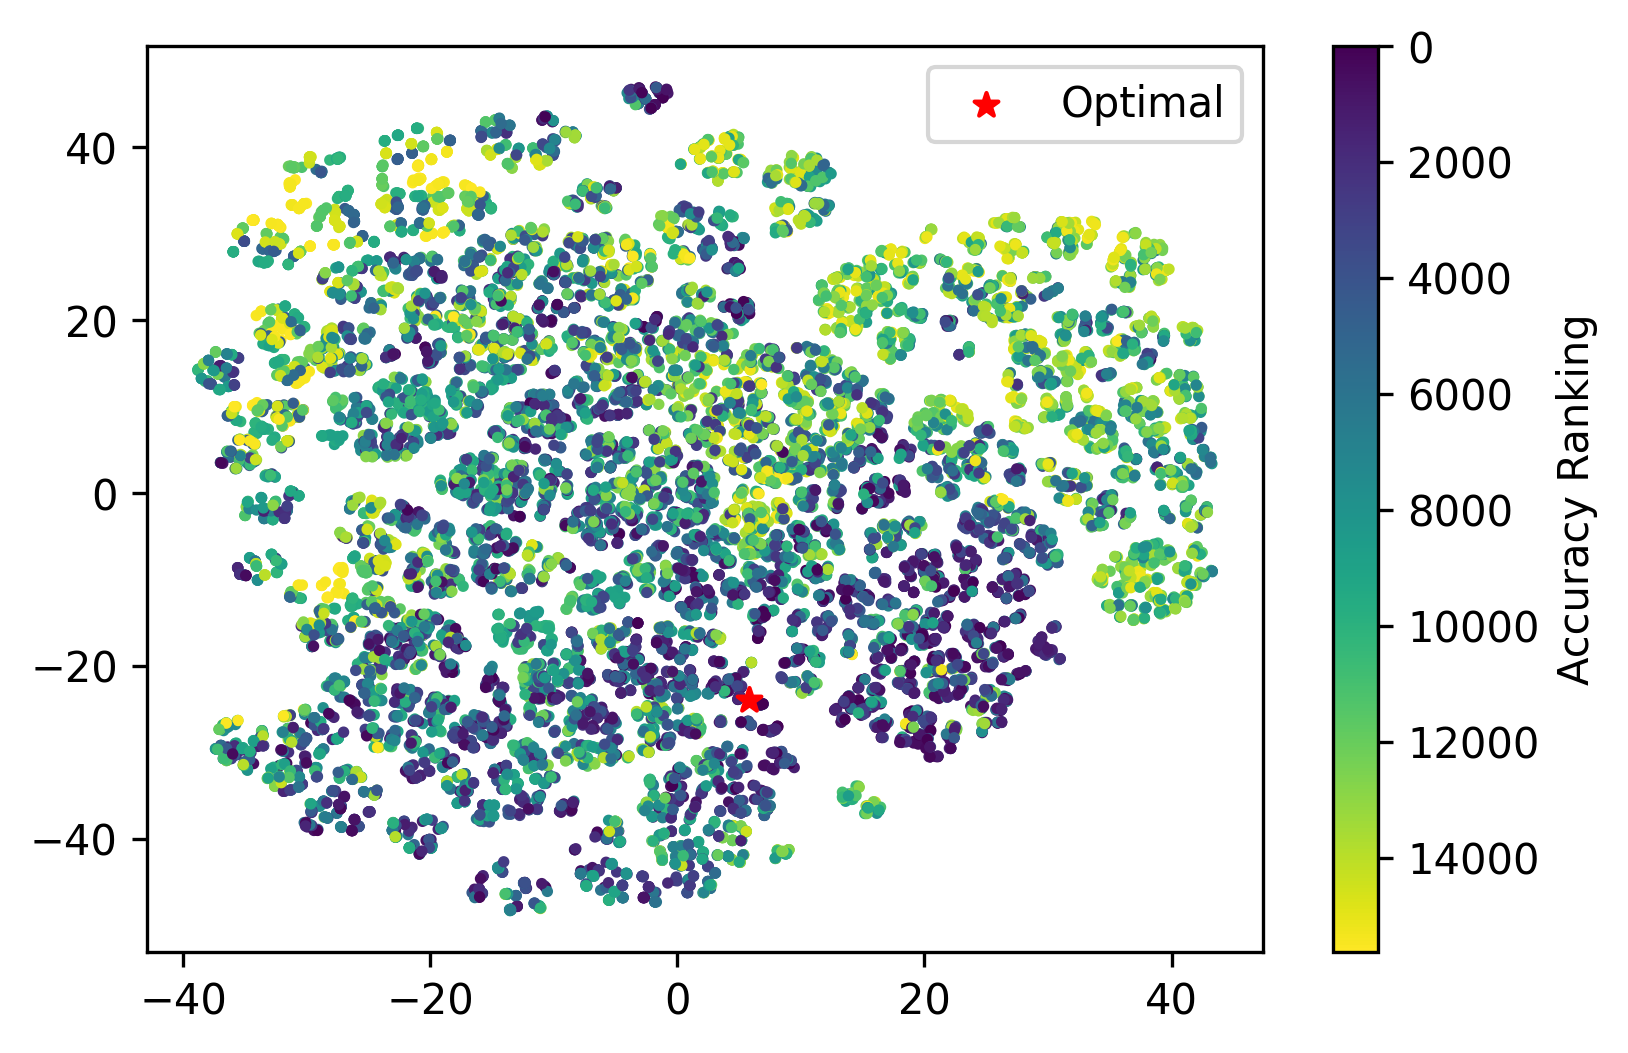

In [62]:
point_size = 3
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=acc_list, cmap='viridis', s=point_size, vmin=0, vmax=15625)
# optimal
optimal = acc_list.tolist().index(0)
print(optimal)
plt.scatter(tsne_result[optimal, 0], tsne_result[optimal, 1], marker='*', color='red', label='Optimal')
plt.legend()
cbar = plt.colorbar(scatter, label='Accuracy Ranking')
cbar.ax.invert_yaxis()
plt.show()

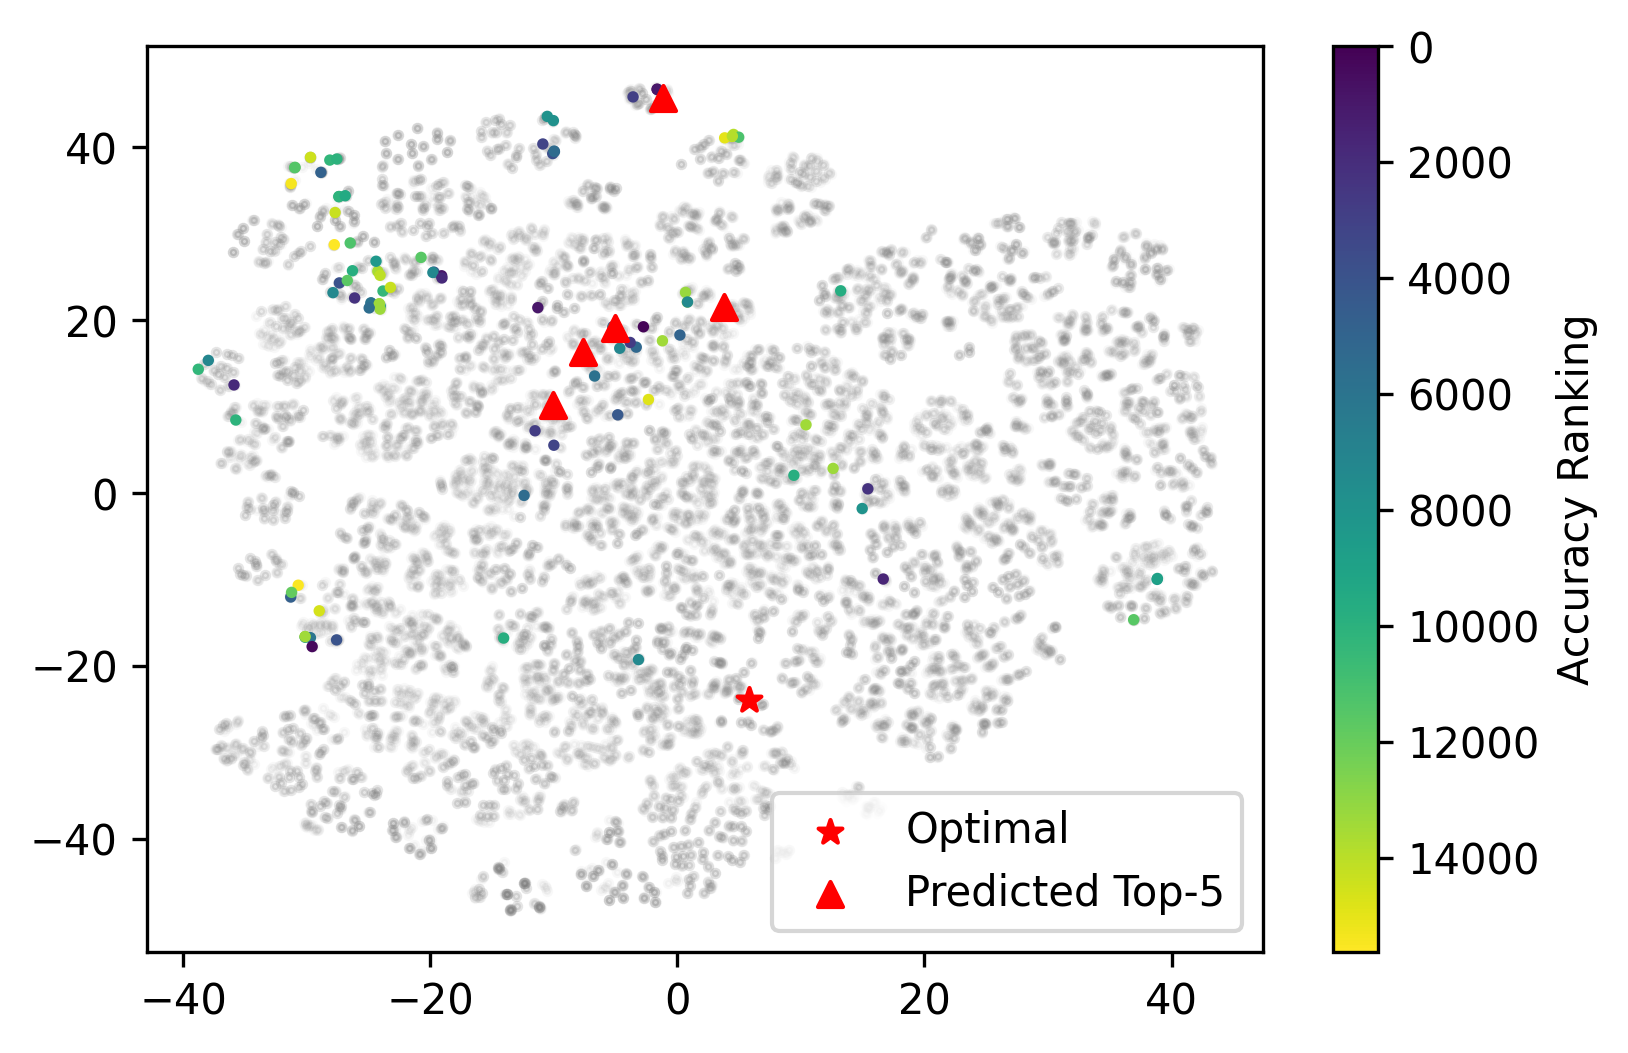

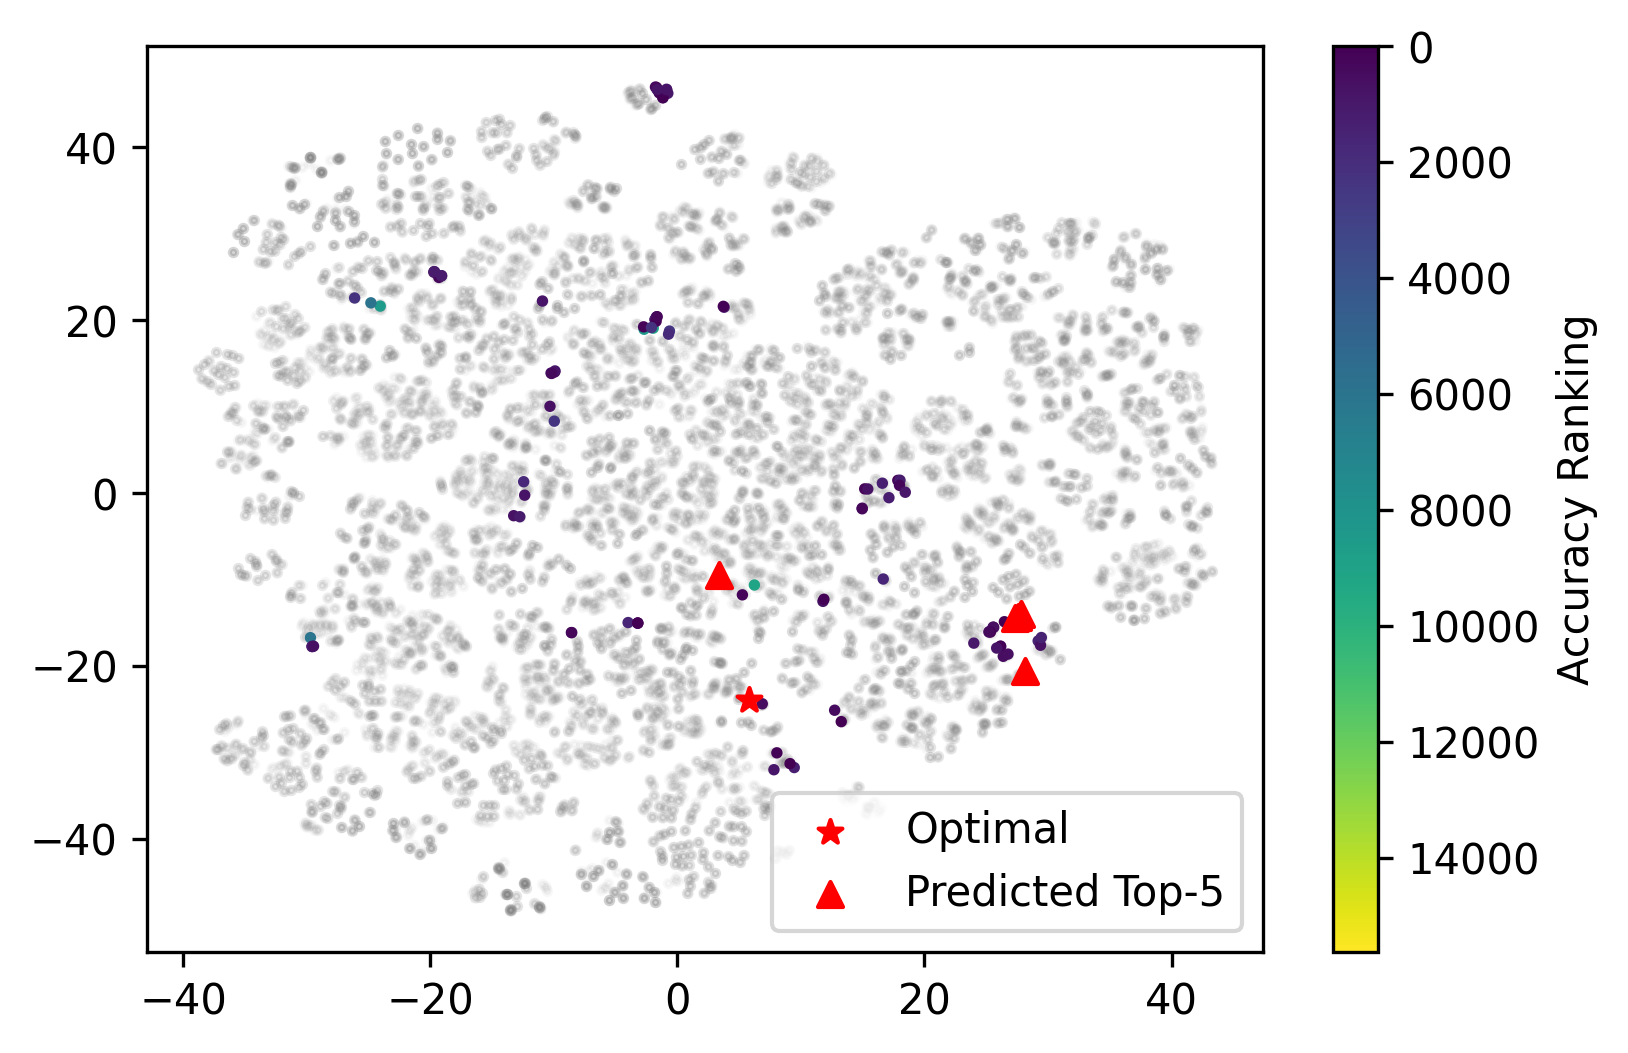

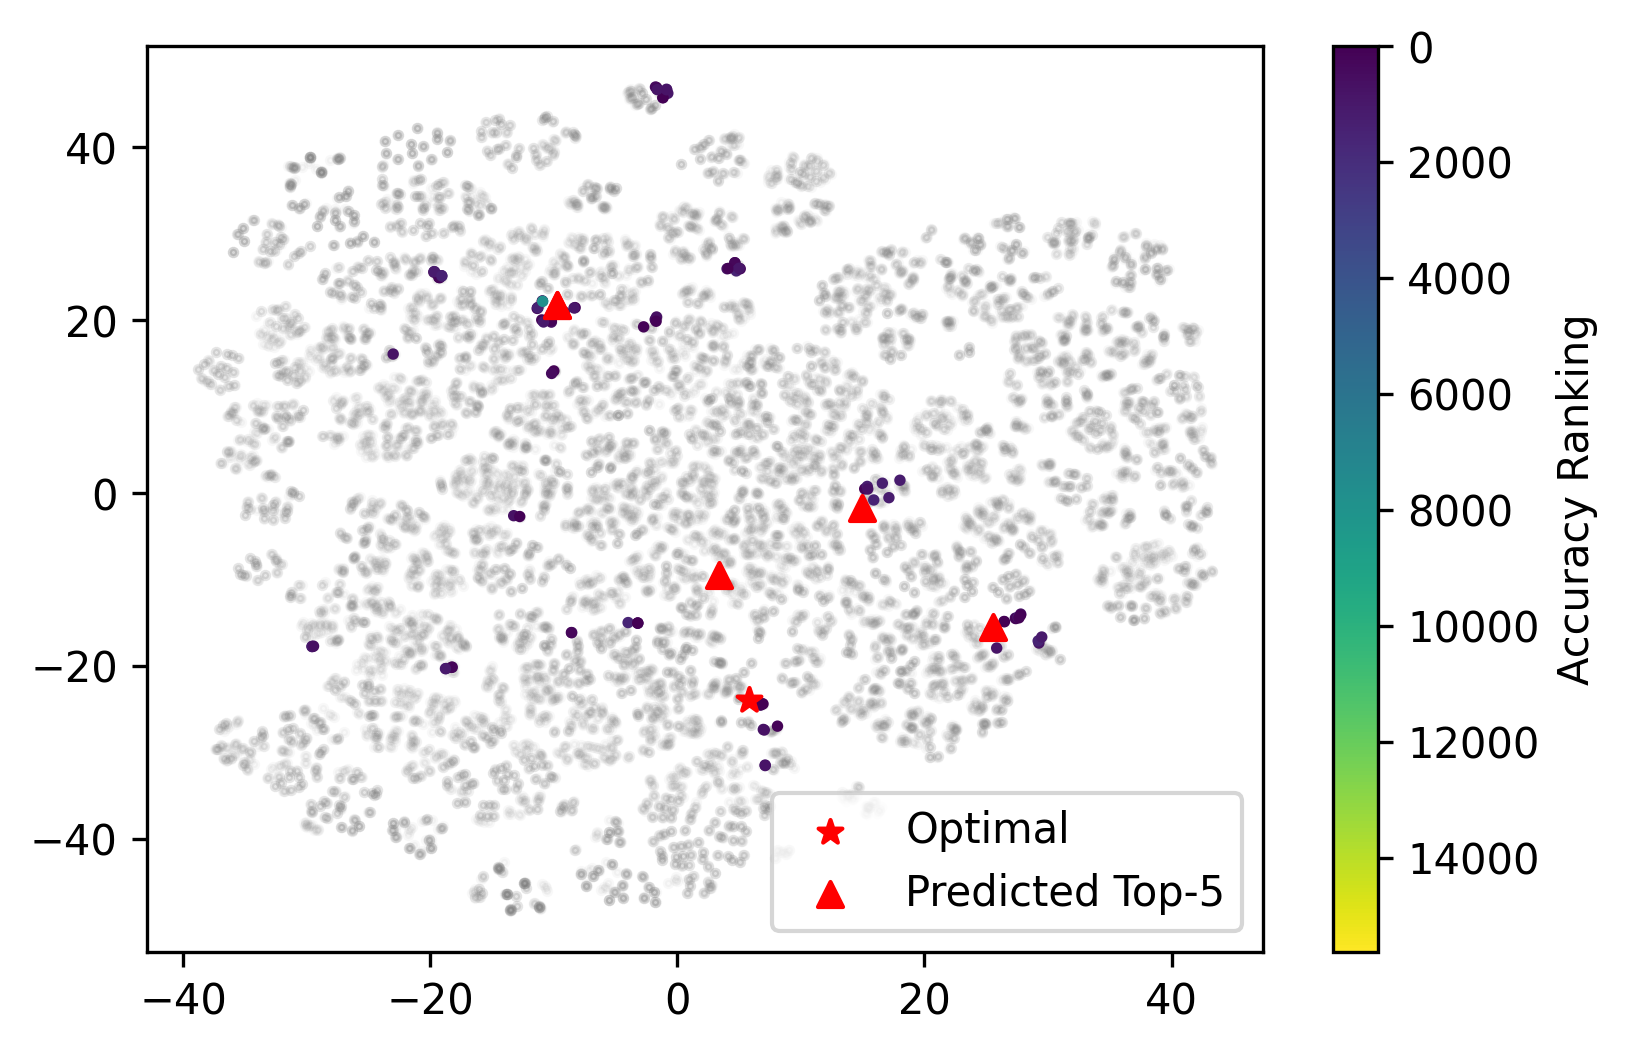

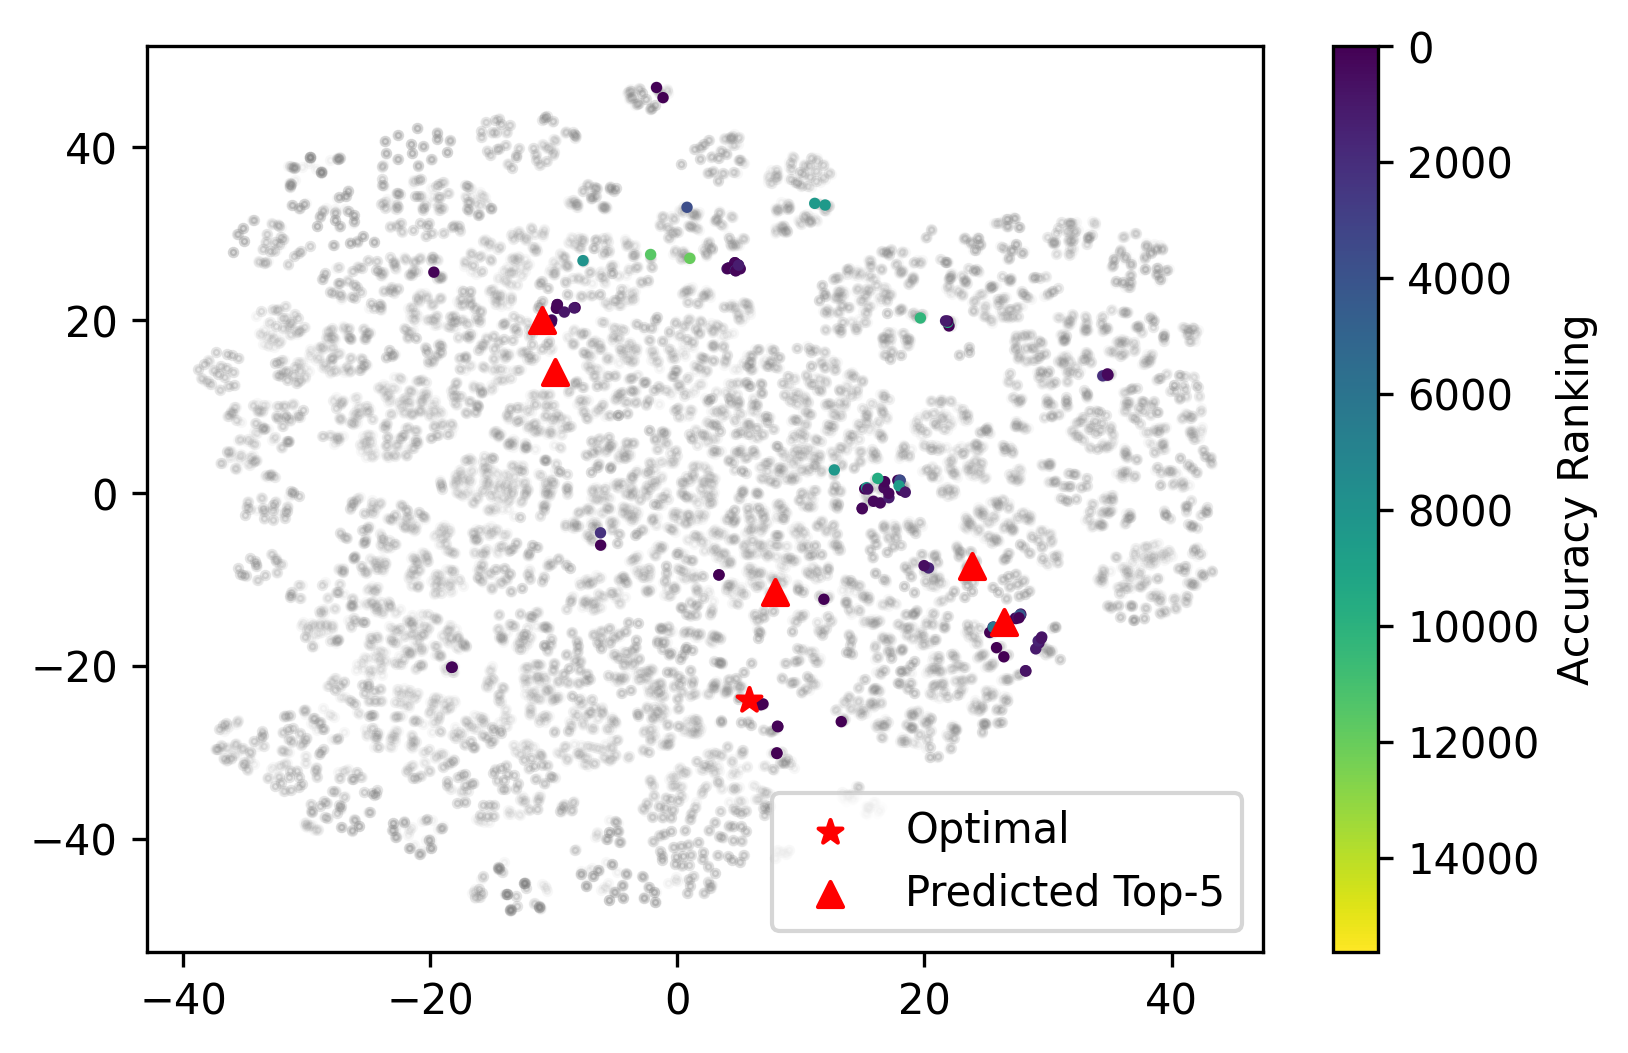

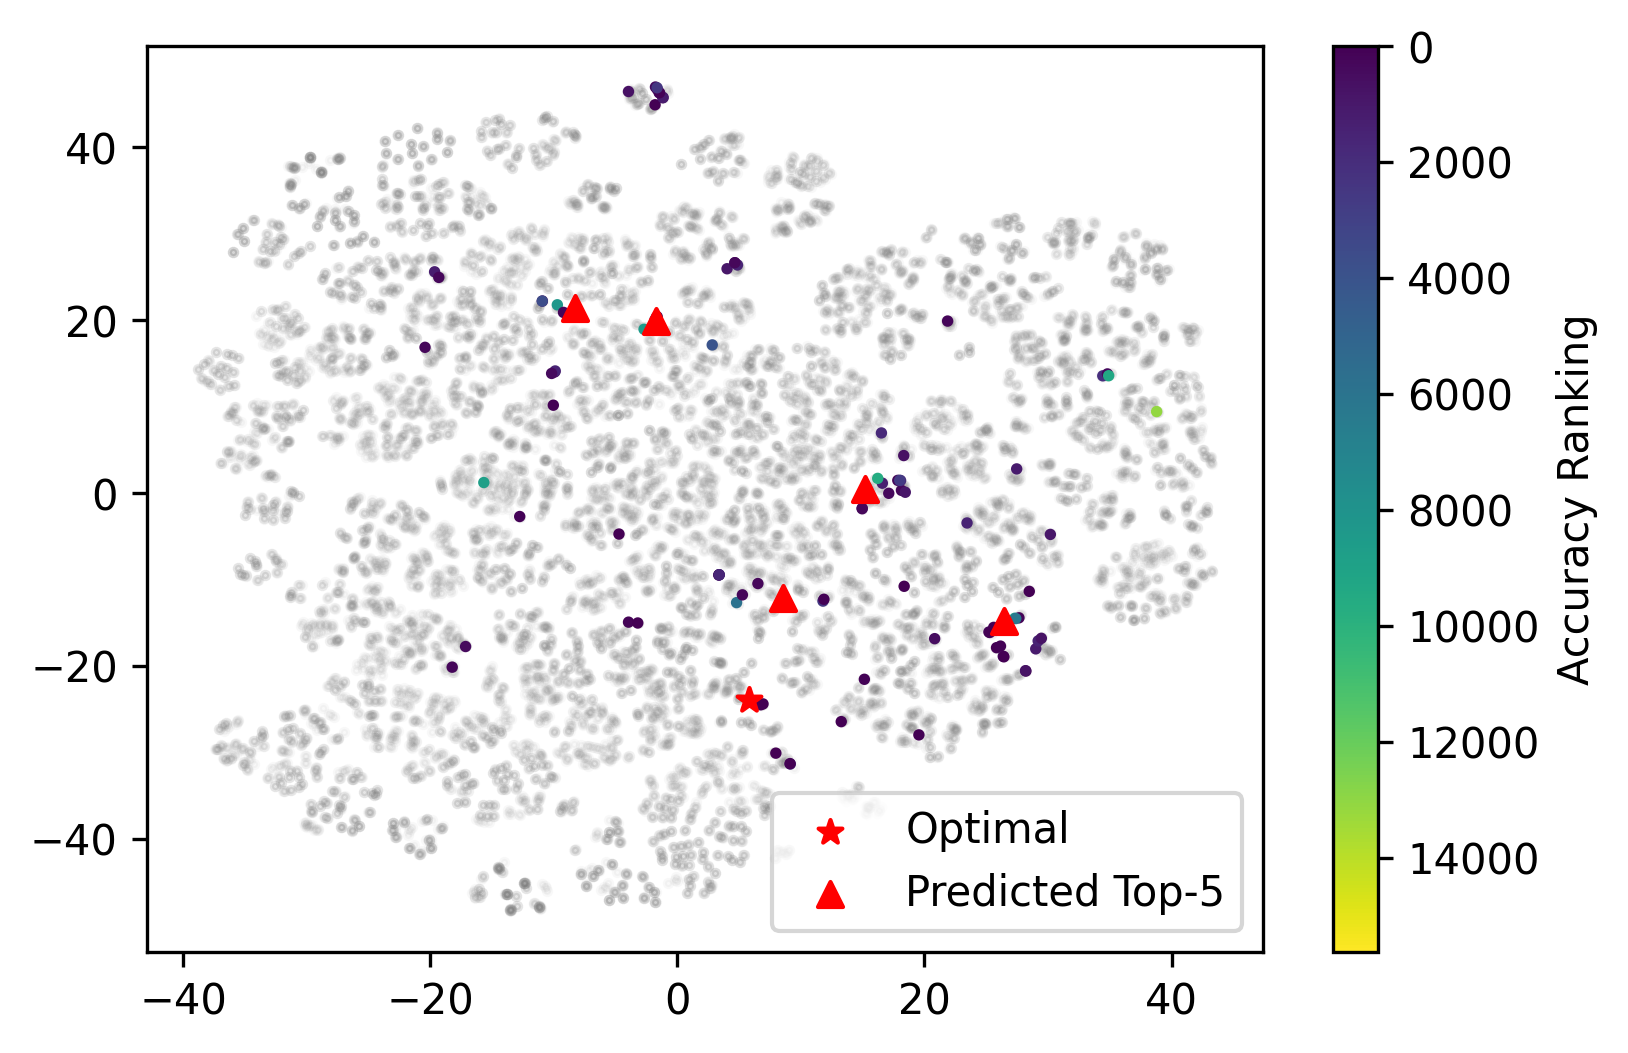

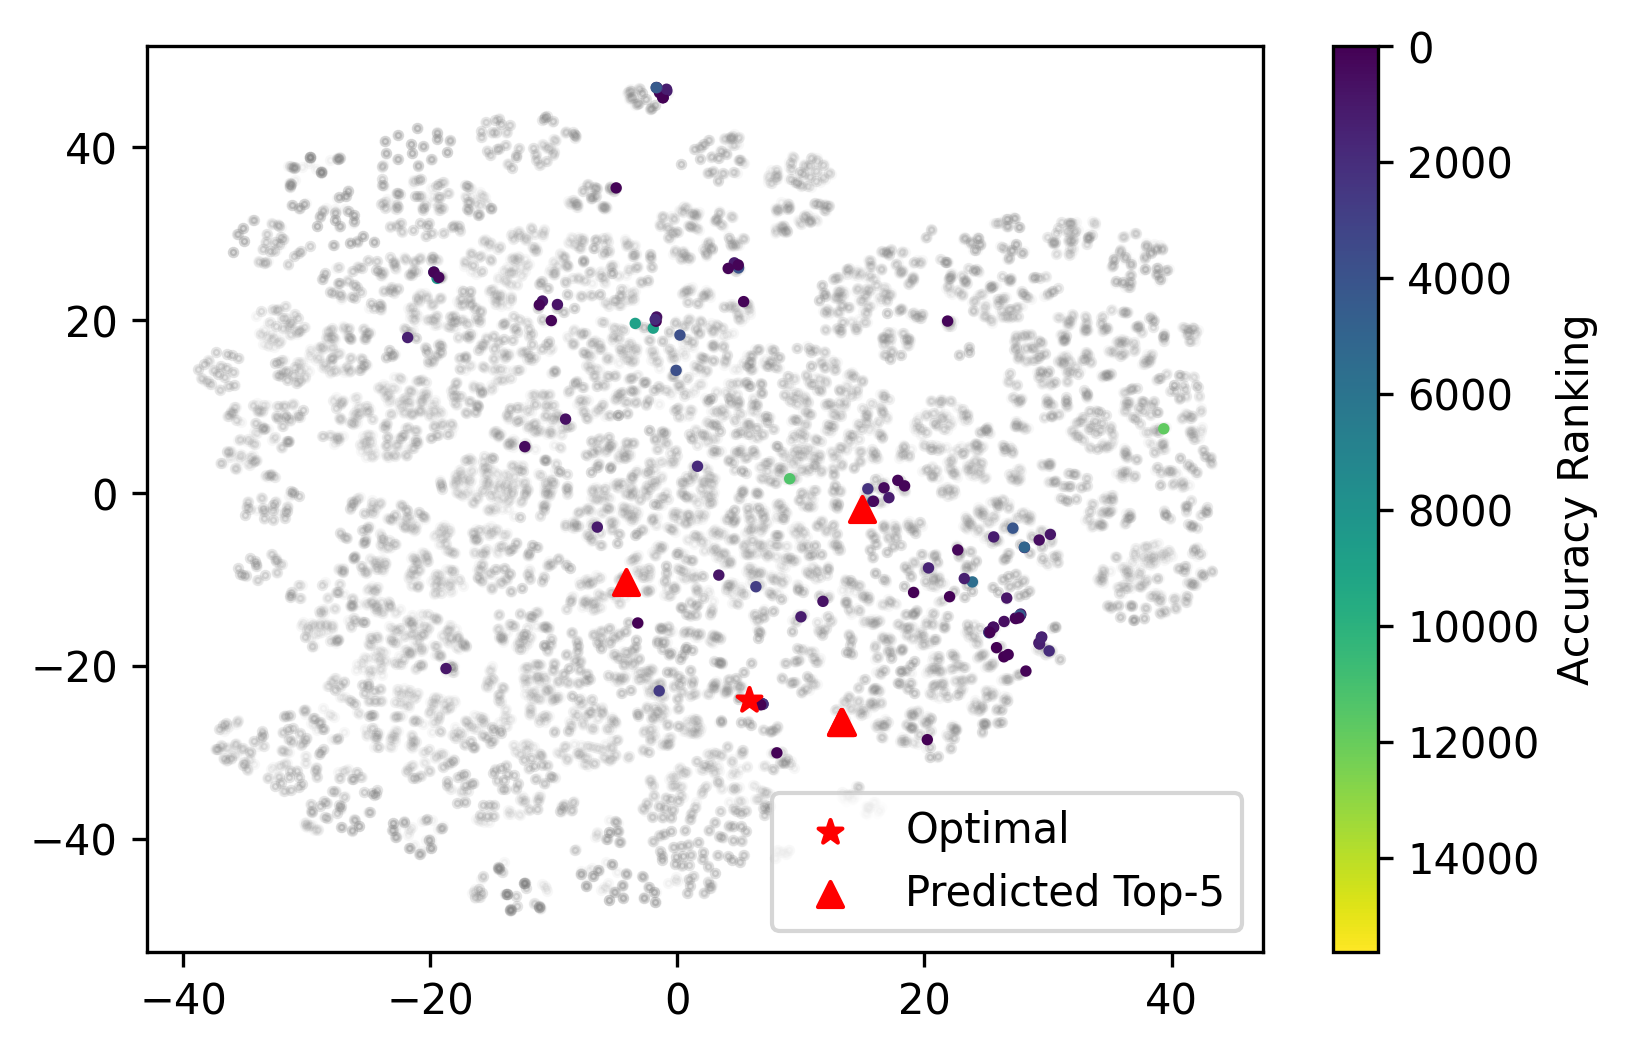

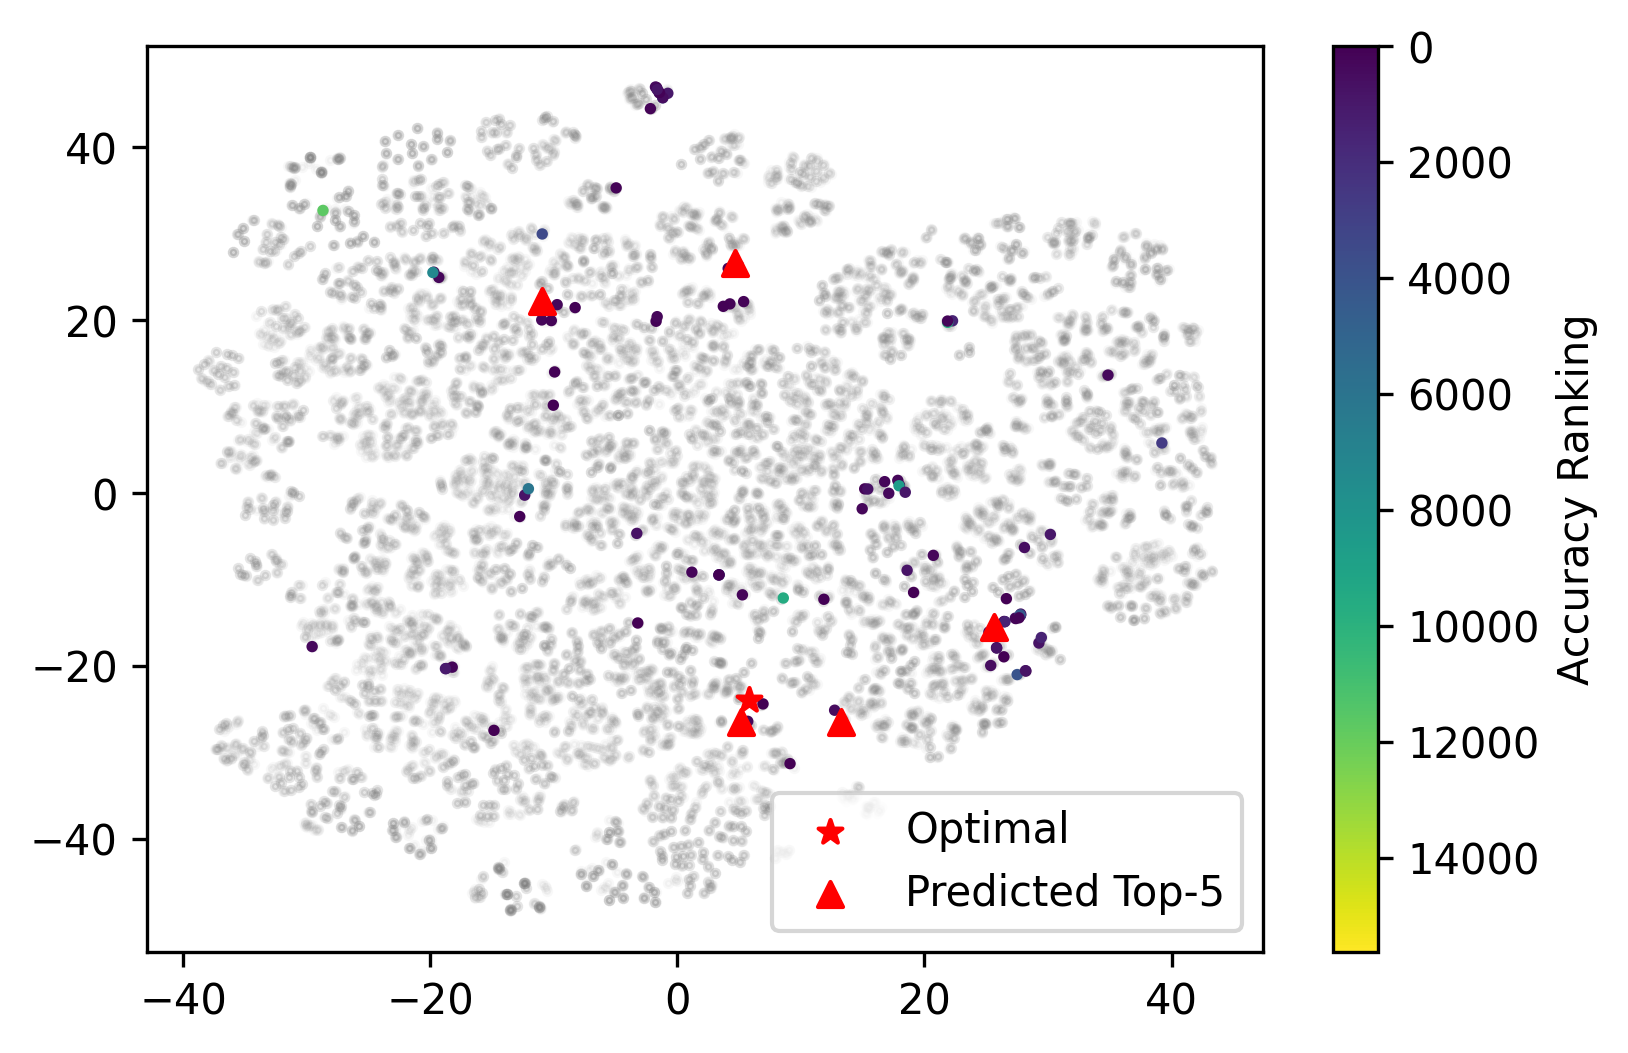

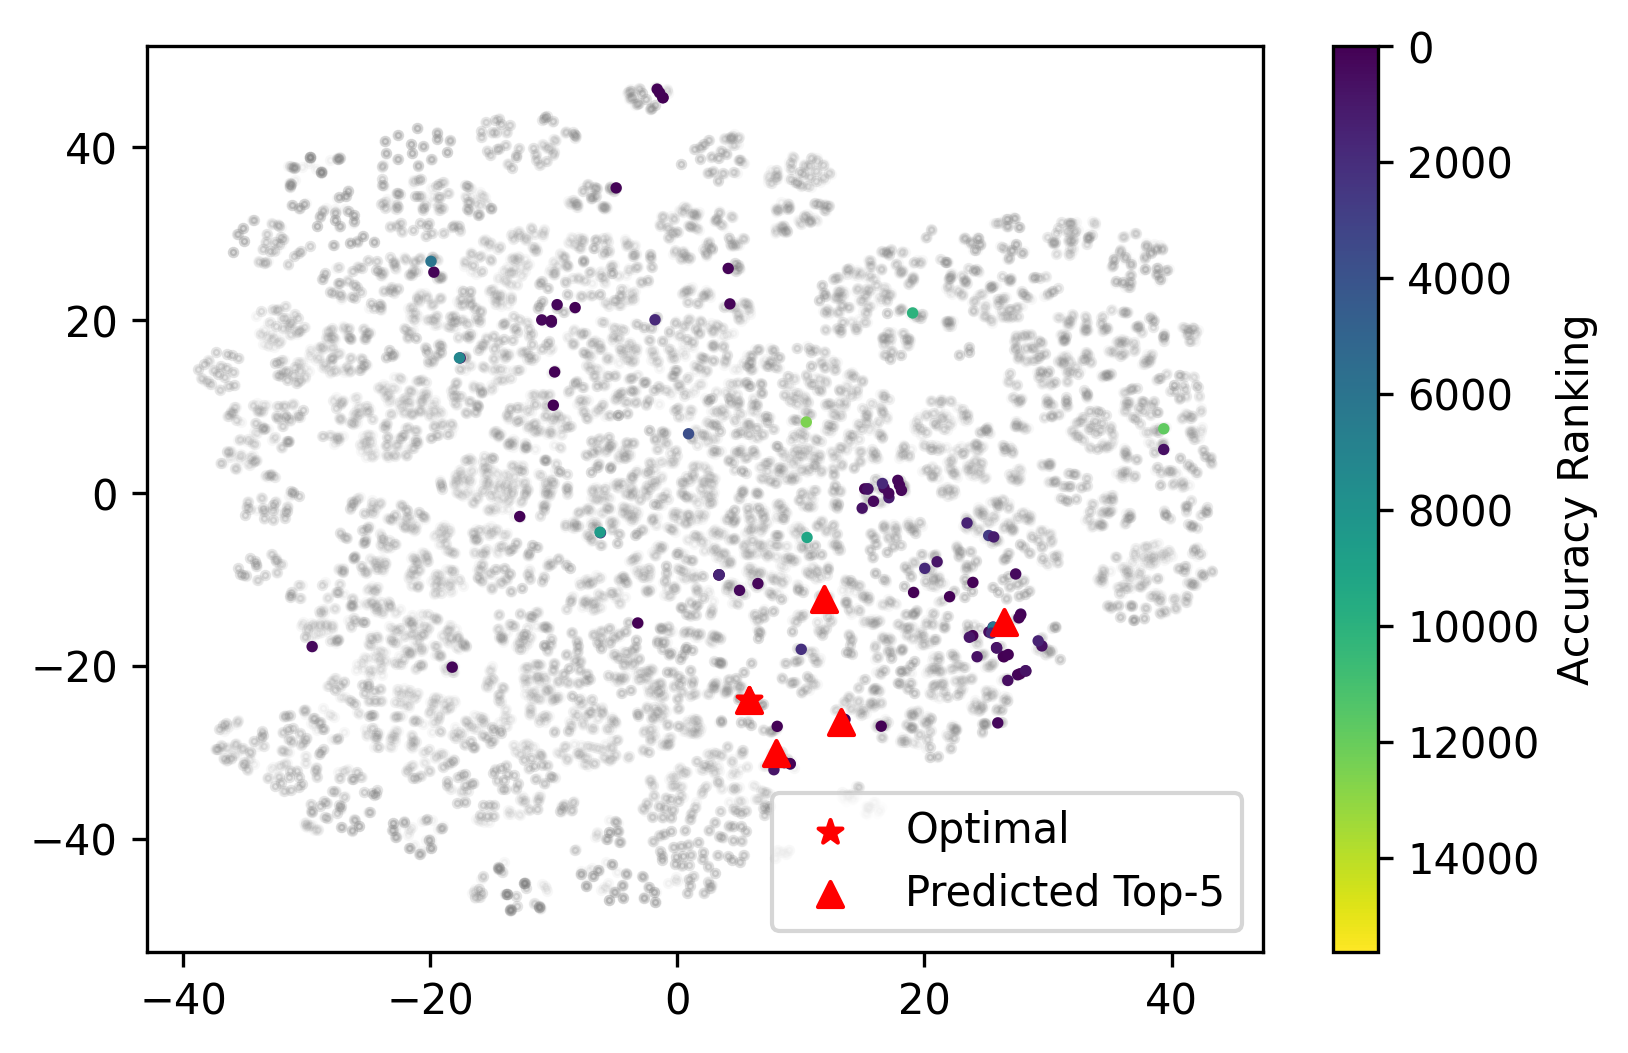

In [63]:
count = 0
for no, found_arch_list_set in enumerate(found_arch_each_round):
    embedding_idx = []
    for i in found_arch_list_set:
        ops_idx = np.argmax(i['x'], axis=-1)
        ops = [OPS_by_IDX_201[i] for i in ops_idx]
        arch_str = ops_list_to_nb201_arch_str(ops)
        index = api.archstr2index[arch_str]
        embedding_idx.append(index)

    #embedding_idx = embedding_idx[: 200]
    mask = np.array([True] * len(embedding_list))
    mask[embedding_idx] = False
    plt.scatter(tsne_result[mask, 0], tsne_result[mask, 1], c='gray', alpha=0.05, s=point_size)

    scatter = plt.scatter(tsne_result[~mask, 0], tsne_result[~mask, 1], c=acc_list[~mask], cmap='viridis', s=point_size, vmin=0, vmax=15625)

    #if no == len(found_arch_each_round) - 1:
    cbar = plt.colorbar(scatter, label='Accuracy Ranking')
    cbar.ax.invert_yaxis()

    # optimal
    optimal = acc_list.tolist().index(0)
    plt.scatter(tsne_result[optimal, 0], tsne_result[optimal, 1], marker='*', color='red', label='Optimal')
    # Predict best
    plt.scatter(tsne_result[embedding_idx[0], 0], tsne_result[embedding_idx[0], 1], marker='^', color='red', label='Predicted Top-5')
    for i in range(1, 5):
        pred_best = embedding_idx[i]
        plt.scatter(tsne_result[pred_best, 0], tsne_result[pred_best, 1], marker='^', color='red')
    plt.legend()
    #plt.title('t-SNE')

    plt.show()
